In [3]:
using Pkg, Revise
#Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot
import DataFrames

In [29]:
using Clapeyron

glycine_data = """Clapeyron Database File
My SolidHfus Parameters
species,Mw,Tm,Hfus
glycine,75.0666,569,13500
"""

like_parameter = """Clapeyron Database File,,,,,,,,,,
SAFTgammaMie Like Parameters [csvtype = like,grouptype = SAFTgammaMie]
species,Mw,vst,S,lambda_r,lambda_a,sigma,epsilon,n_H,n_e1,n_e2
CH2,14.03,1,0.22932,19.871,6,4.8801,473.39,0,0,0
COOH,45.02,1,0.55593,8,6,4.3331,405.78,1,2,2
H2O,18.01528,1,1,17.02,6,3.0063,266.68,2,2,0
NH2,16.02,1,0.79675,10.254,6,3.2477,284.78,2,1,0
"""

unlike_parameter = """Clapeyron Database File,,,
SAFTgammaMie Unlike Parameters [csvtype = unlike,grouptype = SAFTgammaMie]
species1,species2,epsilon,lambda_r
COOH,NH2,285,
COOH,CH2,413.74,
H2O,COOH,289.76,
H2O,NH2,358.55,
H2O,CH2,423.63,
NH2,CH2,348.39,
"""

assoc_parameter = """Clapeyron Database File,,,,,
SAFTgammaMie Assoc Parameters [csvtype = assoc,grouptype = SAFTgammaMie]
species1,site1,species2,site2,epsilon_assoc,bondvol
COOH,H,COOH,H,6427.9,8.062E-31
H2O,e1,COOH,H,2567.7,2.7009E-28
H2O,H,COOH,e1,1451.8,2.8089E-28
H2O,H,COOH,e2,1252.6,1.5098E-28
H2O,H,H2O,e1,1985.4,1.0169E-28
H2O,H,NH2,e1,1460,1.796E-28
H2O,e1,NH2,H,1988.3,5.5824E-29
NH2,e1,NH2,H,1070.8,9.5225E-29
COOH,H,NH2,e1,4000,1E-28
COOH,e1,NH2,H,1446.624,1E-28
COOH,e2,NH2,H,1220.143,1E-28
"""

components = [("water", ["H2O"=>1]), ("glycine", ["NH2"=>1, "CH2"=>1, "COOH"=>1])]

model = CompositeModel(components;
                       fluid = SAFTgammaMie,
                       solid = SolidHfus,
                       solid_userlocations = [glycine_data],
                       fluid_userlocations = [like_parameter,unlike_parameter,assoc_parameter])

println("Sites:         ", model.fluid.sites)
println("bondvol:       ", model.fluid.params.bondvol)
println("epsilon_assoc: ", model.fluid.params.epsilon_assoc)
println("sigma:         ", model.fluid.params.sigma)
println("epsilon:       ", model.fluid.params.epsilon)

# Scan
R = 8.314; T = 298.15; P = 1e5; Tm = 569.0; Hfus = 13500.0
ln_x_ideal = -Hfus/R * (1/T - 1/Tm)

println("\nx_glycine | ln(γ) | γ | f(x)")
for x in [0.01, 0.02, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30]
    z = [1-x, x]
    lnγ = activity_coefficient(model.fluid, P, T, z)
    f = log(x) + lnγ[2] - ln_x_ideal
    println("  $x  |  $(round(lnγ[2],digits=4))  |  $(round(exp(lnγ[2]),digits=4))  |  $(round(f,digits=4))")
end

Sites:         SiteParam["H2O" => ["H" => 2, "e1" => 2], "NH2" => ["H" => 2, "e1" => 1], "CH2" => [], "COOH" => ["H" => 1, "e1" => 2, "e2" => 2]]
bondvol:       AssocParam{Float64}("bondvol")[1.0169e-28, 1.796e-28, 5.5824e-29, 2.8089e-28, 1.5098e-28, 2.7009e-28, 9.5225e-29, 1.0e-28, 1.0e-28, 1.0e-28, 8.062e-31, 8.062e-31]
epsilon_assoc: AssocParam{Float64}("epsilon_assoc")[1985.4, 1460.0, 1988.3, 1451.8, 1252.6, 2567.7, 1070.8, 1446.624, 1220.143, 4000.0, 6427.9, 6427.9]
sigma:         PairParam{Float64}("sigma")["H2O", "NH2", "CH2", "COOH"]
epsilon:       PairParam{Float64}("epsilon")["H2O", "NH2", "CH2", "COOH"]

x_glycine | ln(γ) | γ | f(x)
  0.01  |  1.1145  |  3.0481  |  -0.8982
  0.02  |  0.6735  |  1.961  |  -0.6461
  0.05  |  0.4396  |  1.552  |  0.0363
  0.07  |  0.4144  |  1.5134  |  0.3475
  0.1  |  0.4157  |  1.5155  |  0.7056
  0.15  |  0.4513  |  1.5704  |  1.1466
  0.2  |  0.4993  |  1.6476  |  1.4823
  0.25  |  0.5503  |  1.7337  |  1.7564
  0.3  |  0.601  |  1.824  |  

In [30]:
using Roots

# SLE objective function
function sle_obj(x_glycine)
    z = [1 - x_glycine, x_glycine]
    lnγ = activity_coefficient(model.fluid, P, T, z)
    return log(x_glycine) + lnγ[2] - ln_x_ideal
end

# Bisection between (f<0) and (f>0)
x_solution = find_zero(sle_obj, (0.02, 0.07))
println("Glycine solubility (mole fraction): ", x_solution)

Glycine solubility (mole fraction): 0.047980896202155995


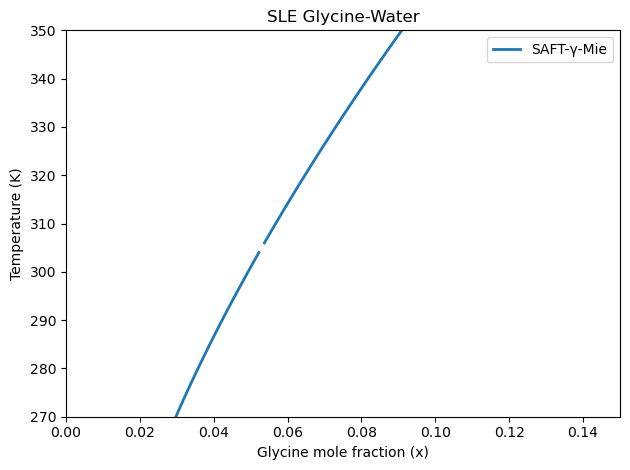

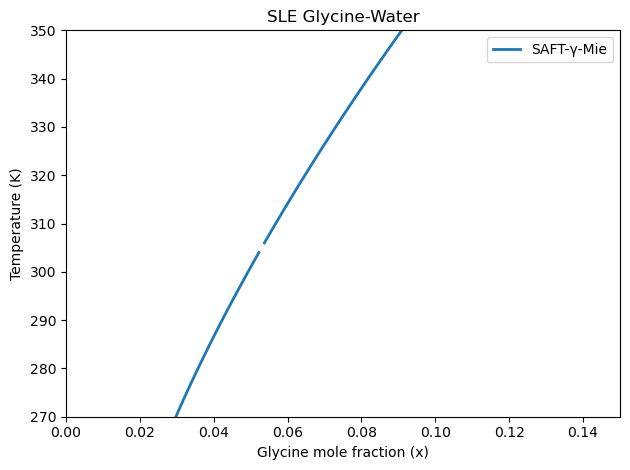

In [43]:
using Clapeyron, Roots

T = LinRange(270., 350., 81)
s = zeros(length(T))

Hfus = 13500.0
Tm   = 569.0
R    = 8.314
P    = 1e5

x_guess = 0.03

for i in 1:length(T)
    Ti = T[i]
    ln_x_ideal = -Hfus/R * (1/Ti - 1/Tm)
    
    function obj_i(x)
        z = [1-x, x]
        lnγ = activity_coefficient(model.fluid, P, Ti, z)
        return log(x) + lnγ[2] - ln_x_ideal
    end
    
    try
        # Use x_guess as starting point instead of fixed bracket
        s[i] = find_zero(obj_i, x_guess)
        
        # Update guess for next temperature (solubility changes smoothly)
        x_guess = s[i]
    catch e
        # If that fails, try a narrow adaptive bracket around the guess
        try
            bracket_low  = max(0.01, x_guess - 0.02)
            bracket_high = min(0.15, x_guess + 0.02)
            s[i] = find_zero(obj_i, (bracket_low, bracket_high))
            x_guess = s[i]
        catch
            s[i] = NaN
        end
    end
end

plt.clf()
plt.plot(s, T, linewidth=2, label="SAFT-γ-Mie")
plt.xlabel("Glycine mole fraction (x)")
plt.ylabel("Temperature (K)")
plt.title("SLE Glycine-Water")
plt.xlim(0, 0.15)
plt.ylim(270, 350)
plt.legend()
plt.tight_layout()
display(plt.gcf())

In [44]:
using DataFrames

df = DataFrame(
    Temperature_K = T,
    x_glycine = s)

println(df)

81×2 DataFrame
 Row │ Temperature_K  x_glycine   
     │ Float64        Float64     
─────┼────────────────────────────
   1 │         270.0    0.0297694
   2 │         271.0    0.0303446
   3 │         272.0    0.0309254
   4 │         273.0    0.0315117
   5 │         274.0    0.0321036
   6 │         275.0    0.0327009
   7 │         276.0    0.0333038
   8 │         277.0    0.033912
   9 │         278.0    0.0345257
  10 │         279.0    0.0351447
  11 │         280.0    0.035769
  12 │         281.0    0.0363986
  13 │         282.0    0.0370334
  14 │         283.0    0.0376735
  15 │         284.0    0.0383187
  16 │         285.0    0.038969
  17 │         286.0    0.0396244
  18 │         287.0    0.0402849
  19 │         288.0    0.0409504
  20 │         289.0    0.0416208
  21 │         290.0    0.0422963
  22 │         291.0    0.0429766
  23 │         292.0    0.0436618
  24 │         293.0    0.0443518
  25 │         294.0    0.0450467
  26 │         295.0    0.0457463